# Initialization

### Stream Generation and Sketch Setup

- **Stream Details**:
  - 100,000 elements sampled from 10,000 unique integers.
  - Shuffled for a realistic data flow, with reproducibility ensured by a fixed seed.

- **Sketch Sizes**: `[100, 300, 1000, 3000, 10000, 30000, 50000]`.

- **Purpose**: Prepares data to test the FM algorithm's accuracy in estimating unique elements with varying memory sizes.

In [197]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000
NUM_UNIQUE = 10000
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)

stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

num_unique_elements = len(np.unique(stream))

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {num_unique_elements}")
print(f"First 10 elements of the stream: {stream[:10]}")

# Logarithmically increasing sketch sizes (between 10 and 100000)
sketch_sizes = [2**i for i in range(4, 17)]
print(f"Sketch sizes: {sketch_sizes}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]
Sketch sizes: [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]


These functions hash elements and streams, ensuring uniform distribution between 0 and 1 for use in estimations.

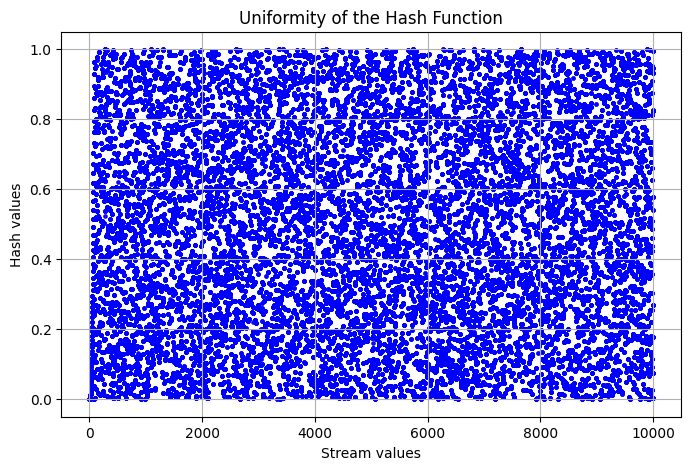

In [198]:
import matplotlib.pyplot as plt

# Prime number for the hash function, P > NUM_UNIQUE
P = 2**19 - 1

def hash_stream(stream: np.ndarray, a: int, b: int, c: int, d: int, p: int = P) -> np.ndarray:
    return ((a * stream**3 + b * stream**2 + c * stream + d) % p) / p

# Plot the uniformity of the hash function
hashes = hash_stream(stream, 1, 2, 3, 4)

plt.figure(figsize=(8, 5))
plt.scatter(stream, hashes, alpha=0.7, color='blue', s=5)
plt.title("Uniformity of the Hash Function")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [199]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    a, b, c, d = np.random.default_rng(SEED).integers(1, P, size=4)
    hashed_stream = hash_stream(stream, a, b, c, d)
    return 1 / np.min(hashed_stream)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin(stream):.2f}")

Estimated number of unique elements: 4064.24


### Flajolet Martin - Beta Version

In [200]:
def flajolet_martin_beta(stream: np.ndarray, s: int) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :return: estimated number of distinct elements
    """
    abcd_vals = np.random.default_rng(SEED).integers(1, P, size=(s, 4))
    estimates = [hash_stream(stream, a, b, c, d) for a, b, c, d in abcd_vals]    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_beta(stream, 100):.2f}")

Estimated number of unique elements: 11050.58


### Flajolet Martin - Final Version

In [201]:
def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """
    abcd_vals = np.random.default_rng(SEED).integers(1, P, size=(t, s, 4))
    
    Zs = [np.min([hash_stream(stream, a, b, c, d) for a, b, c, d in abcd_vals[i]], axis=1) for i in range(t)]
    estimates = [1 / np.mean(Z) - 1 for Z in Zs]
        
    return np.median(estimates)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_final(stream, 3, 100):.2f}")

Estimated number of unique elements: 9793.26


Run 25 times for each sketch size

In [202]:
delta = 0.05  # 95% confidence interval
delta_beta = 1 / 3
penalty = 10  # Penalty for the number of FM-beta estimators, while keeping the space complexity constant

def process_sketch(sketch_size: int, verbose: bool = False) -> tuple:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: tuple of FM, FM-beta, and FM-final estimates
    """
    # Maintain 10 * O(log(1/delta)/epsilon^2) space complexity to ensure 95% success probability
    epsilon = np.sqrt(penalty * np.log(1 / delta) / sketch_size)
    
    print("=====================================")
    print(f"Sketch size: {sketch_size}")
    print(f"Relative error (epsilon) that guarantees 95% success probability: {epsilon:.2f}") 
    
    # Calculate the number of FM-beta estimators and the number of FM estimators per FM-beta estimator
    t = int(np.ceil(np.log(1 / delta)))  # Multiply by 3 to increase the success probability
    s = int(np.ceil(1 / (delta_beta * (epsilon**2))))
    print(f"FM-beta instances (t): {t}, FM instances per FM-beta (s): {s}")
    
    # Single run processing for each of the FM, FM-beta, and FM-final algorithms
    def process_run(sketch: np.ndarray, index: int) -> float:
        fm_results, fm_beta_results, fm_final_results = flajolet_martin(sketch), flajolet_martin_beta(sketch, s), flajolet_martin_final(sketch, t, s)
        if verbose:
            print(f"Sketch size: {sketch_size}, Run: {index+1}/{NUM_RUNS}, Number of unique elements: {len(np.unique(sketch))}, FM estimate: {fm_results:.2f}, FM-beta estimate: {fm_beta_results:.2f}, FM-final estimate: {fm_final_results:.2f}")
        return fm_results, fm_beta_results, fm_final_results

    # Generate random indices for the stream
    indices = [np.random.choice(len(stream), size=sketch_size, replace=False) for _ in range(NUM_RUNS)]
    
    # Process the runs
    fm_results, fm_beta_results, fm_final_results = zip(*[process_run(stream[index], i) for i, index in enumerate(indices)])
    print(f"Average FM estimate: {np.mean(fm_results):.2f}, Average FM-beta estimate: {np.mean(fm_beta_results):.2f}, Average FM-final estimate: {np.mean(fm_final_results):.2f}")
    
    return fm_results, fm_beta_results, fm_final_results

print(f"True number of unique elements: {num_unique_elements}")
results = [process_sketch(sketch_size) for sketch_size in sketch_sizes]

True number of unique elements: 10000
Sketch size: 16
Relative error (epsilon) that guarantees 95% success probability: 1.37
FM-beta instances (t): 3, FM instances per FM-beta (s): 2
Average FM estimate: 29.15, Average FM-beta estimate: 22.25, Average FM-final estimate: 22.06
Sketch size: 32
Relative error (epsilon) that guarantees 95% success probability: 0.97
FM-beta instances (t): 3, FM instances per FM-beta (s): 4
Average FM estimate: 203.32, Average FM-beta estimate: 51.76, Average FM-final estimate: 35.64
Sketch size: 64
Relative error (epsilon) that guarantees 95% success probability: 0.68
FM-beta instances (t): 3, FM instances per FM-beta (s): 7
Average FM estimate: 159.83, Average FM-beta estimate: 77.89, Average FM-final estimate: 69.38
Sketch size: 128
Relative error (epsilon) that guarantees 95% success probability: 0.48
FM-beta instances (t): 3, FM instances per FM-beta (s): 13
Average FM estimate: 527.25, Average FM-beta estimate: 141.15, Average FM-final estimate: 129.18

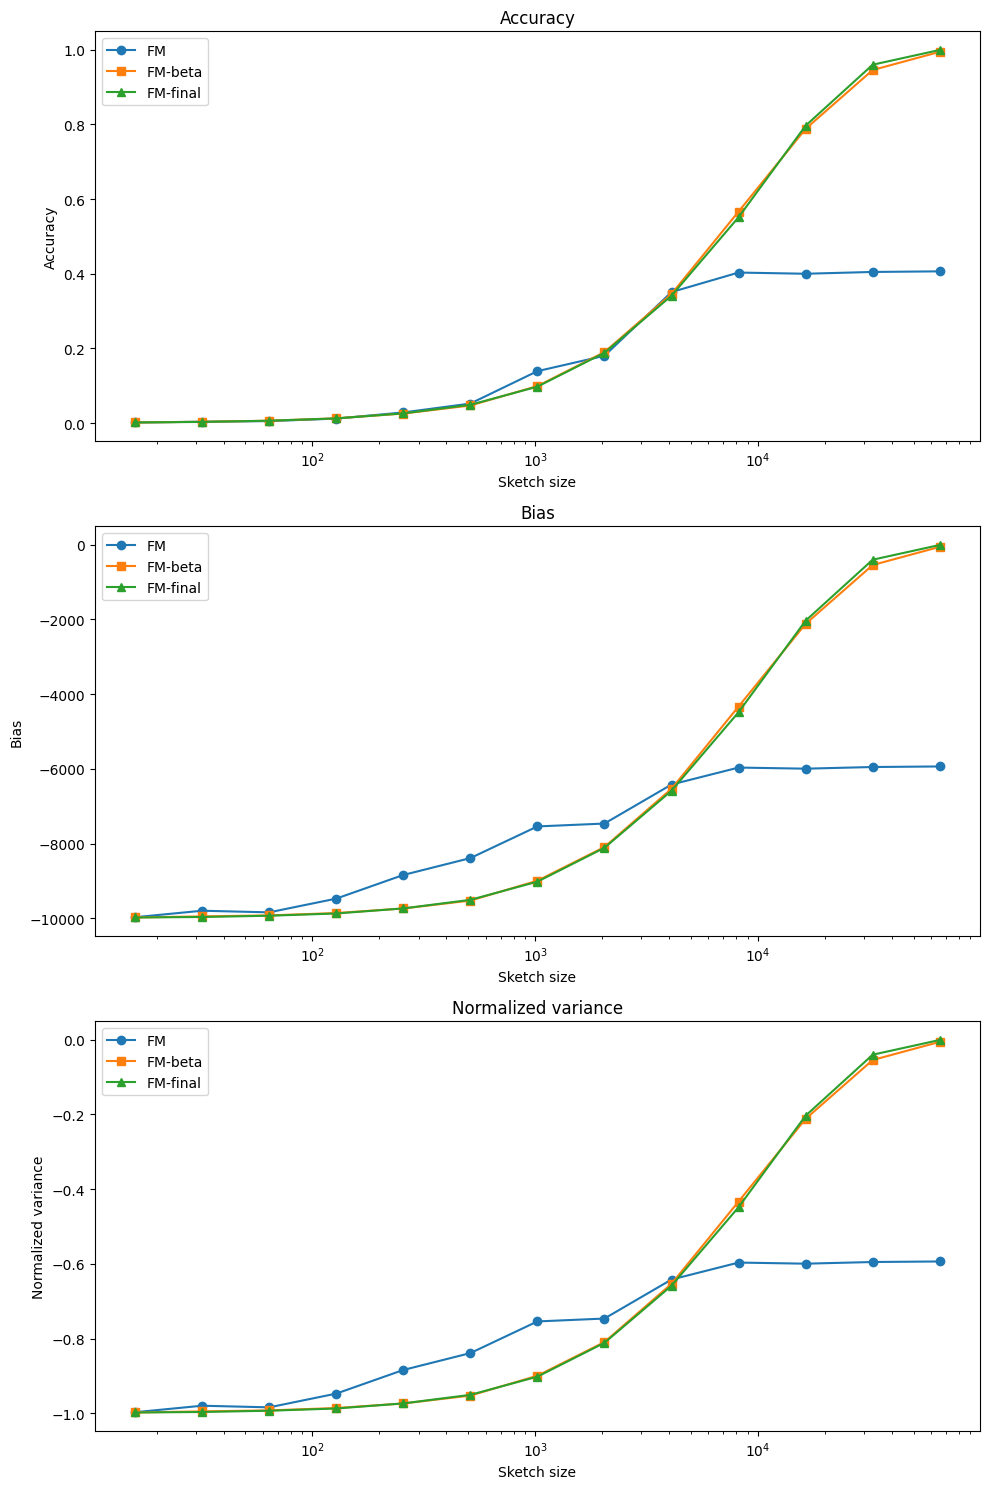

In [203]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fm_results = {sketch_size: results[i][0] for i, sketch_size in enumerate(sketch_sizes)}
fm_beta_results = {sketch_size: results[i][1] for i, sketch_size in enumerate(sketch_sizes)}
fm_final_results = {sketch_size: results[i][2] for i, sketch_size in enumerate(sketch_sizes)}

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": stats.hmean([max(0, 1 - abs(est - num_unique_elements) / num_unique_elements) for est in size_estimates]),
            "bias": np.mean([est - num_unique_elements for est in size_estimates]),
            "normalized_variance": np.mean([((est - num_unique_elements) / num_unique_elements) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM", marker='o')
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta", marker='s')
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final", marker='^')
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()

## Count-Min Sketch

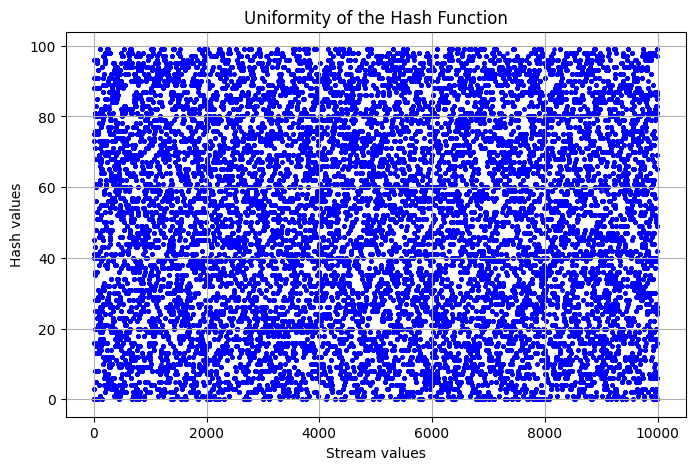

In [401]:
def hash_stream_to_indices(stream: np.ndarray, ab_vals: list, w: int) -> np.ndarray:
    """
    Hash the stream elements to indices using the given hash function.
    :param stream: numpy array of elements
    :param ab_vals: list of tuples containing a and b values
    :param w: width of the sketch
    :return: numpy array of hashed indices
    """
    return np.array([((a * stream**3 + b * stream**2) % P) % w for a, b in ab_vals]).T

# Plot the uniformity of the hash function
hashes = hash_stream_to_indices(stream, [(1, 2), (3, 4)], 100)

plt.figure(figsize=(8, 5))
plt.scatter(stream, hashes[:, 0], alpha=0.7, color='blue', s=5)
plt.title("Uniformity of the Hash Function")
plt.xlabel("Stream values")
plt.ylabel("Hash values")
plt.grid(True)
plt.show()

In [ ]:
def count_min_sketch(stream: np.ndarray, w: int, d: int) -> np.ndarray:
    """
    Count-Min Sketch algorithm for counting the frequency of elements in a stream.
    :param stream: numpy array of elements
    :param w: width of the sketch
    :param d: depth of the sketch
    :return: frequencies for each element in the stream, according to the sketch
    """
    # Initialize the sketch
    sketch = np.zeros((d, w), dtype=np.int32)
    
    ab_vals = np.random.default_rng(SEED).integers(1, w, size=(d, 2))
    indices = hash_stream_to_indices(stream, ab_vals, w)
    
    # Update the sketch with the stream elements according to the hashed indices
    for i, element in enumerate(stream):
        for j in range(d):
            sketch[j, indices[i, j]] += 1
            
    # Return frequencies for each element in the stream
    freqs = {}
    for i, element in enumerate(stream):
        freqs[element] = min([sketch[j, indices[i, j]] for j in range(d)])
        
    return freqs

# Sanity check
# Space complexity = O(log(F_1) * log(1 / delta) * (1 / epsilon))
F1 = np.max(np.unique(stream, return_counts=True)[1])
delta = 0.05
d = int(np.ceil(np.log2(1 / delta)))
epsilon = int(np.ceil(np.log(1 / delta) / len(stream)))
w = int(np.ceil(2 / epsilon))

print(f"Epsilon: {epsilon}, Width: {w}, Depth: {d}")
freqs = count_min_sketch(np.array(stream), w, d)
real_freqs = {element: freq for element, freq in zip(*np.unique(stream, return_counts=True))}
print(freqs[10], real_freqs[10])

Epsilon: 1, Width: 2, Depth: 5
49976 13
